In [14]:
from wandb.keras import WandbCallback
import wandb
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow import convert_to_tensor
import numpy as np
from transformers import TFDistilBertModel
from extract_bert_features import embed, make_pipe
from model_k import create_model
from scipy.spatial.distance import cosine
from tensorflow.keras.callbacks import EarlyStopping
from progress.bar import Bar
import pandas as pd

from timer import timer

import matplotlib.pyplot as plt

from spacyNER import get_spacy_NER_data


In [2]:

emb_pipe = make_pipe('distilbert-base-uncased', TFDistilBertModel)

early_stopping_cb = EarlyStopping(
    monitor='loss', patience=3, verbose=1, min_delta=0.001)

Couldn't find program: 'echo'


In [ ]:
ae_model = compile_ae_model()

# # some fake data
# fake_train_x = np.random.rand(1000, 768)
# fake_test_x = np.random.rand(500, 768)
# fake_train_y = np.random.rand(1000, 1)
# fake_test_y = np.random.rand(500, 1)
# ae_model.fit(
#     x=fake_train_x,
#     y=fake_train_y,
#     epochs=5,
#     batch_size=100,
#     shuffle=True,
#     validation_data=(fake_test_x, fake_test_y))


In [ ]:


def test():
    z = ['The brown fox jumped over the dog',
         'The ship sank in the Atlantic Ocean',
         'Urban foxes sometimes fight with dogs']
    print("Start")
    embedding_features1 = embed(emb_pipe, z[0])
    print(
        f"emb shape is {embedding_features1.shape} for {len(z[0].split(' '))} words")
    embedding_features2 = embed(emb_pipe, z[1])
    embedding_features3 = embed(emb_pipe, z[2])
    distance12 = 1-cosine(embedding_features1[0], embedding_features2[0])
    distance23 = 1-cosine(embedding_features2[0], embedding_features3[0])
    distance13 = 1-cosine(embedding_features1[0], embedding_features3[0])
    print(f"distance 1-2 {distance12}")
    print(f"distance 2-3 {distance23}")
    print(f"distance 1-3 {distance13}")

In [ ]:
# create 1 training item per entity, given a token radius


@timer
def create_training_data_per_entity(
        length: int = 10,
        radius: int = 7) -> list:
    """
    Creates training data for the autoencoder.
    """
    print(f"Create Training Data for {length} items, radius {radius}")
    # get spacy data
    spacy_data = get_spacy_NER_data(length)
    print(f"Created NER Data for {len(spacy_data)} items")

    # get embedding data
    res = []
    bar = Bar('Processing', max=len(spacy_data))
    for s in spacy_data:
        for chunk in s["chunks"]:
            start_token = max(chunk["entity"].start-radius, 0)
            end_token = min(chunk["entity"].end+radius, len(s["nlp"]))
            short_sentence = s["nlp"][start_token:end_token]
            res.append({
                "sentence": short_sentence,
                "chunk": str(chunk["chunk"]),
                "label": chunk["entity"].label_,
                "embedding": embed(emb_pipe, str(short_sentence))
            })
            bar.next()
    bar.finish()
    # average all the embeddings in a sample, dropping 1st (CLS)
    for r in res:
        r["embedding"] = np.mean(r["embedding"][1:], axis=0)
    return res



In [ ]:
# 
# CREATE TRAINING DATA
merged = create_training_data_per_entity(-1, 5)
print(len(merged))


In [ ]:
# create full DF

x_train_np = np.stack([m["embedding"] for m in merged])

merged_df = pd.DataFrame(merged)
emb_df = pd.DataFrame(x_train_np)

merged_df.drop(columns=['embedding'], inplace=True)
df = pd.concat([merged_df, emb_df], axis=1)

print(df.shape)
# save data to csv
df.to_csv("./data/training_df.csv", index=False)
df.head()

# IMPORT import df from file


In [15]:
df = pd.read_csv("./data/training_df.csv")


# train df has only the embeddings
df.head()

def test_train_split(frac=0.8):
    training_data = df.sample(frac=frac, random_state=42)
    testing_data = df.drop(training_data.index)
    train_x_df = training_data.drop(columns=['chunk', 'label', 'sentence'])
    test_x_df = testing_data.drop(columns=['chunk', 'label', 'sentence'])
    print(f"Full df: {df.shape}")
    print(f"Train df: {train_x_df.shape}")
    print(f"Test df: {test_x_df.shape}")
    return train_x_df, test_x_df
train_x, test_x = test_train_split(0.8)

Full df: (3895, 771)
Train df: (3116, 768)
Test df: (779, 768)


In [16]:
# plot loss
# summarize history for loss
def plot_loss(history) -> None:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('validation')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


grid search

In [17]:
default = {
    "ae": [
        {"n": 768, "act": "relu"},
        {"n": 500, "act": "relu"},
        {"n": 2000, "act": "relu"},
    ],
    "repr": [
        {"n": 2000, "act": "relu"},
        {"n": 768, "act": "relu"},
        {"n": 768, "act": "relu"},
    ],
    "latent": {"n": 160, "act": "relu"},
    "output": "sigmoid",
    "opt": "adam",
    "loss": "mse",
    "lr": 0.001,
    "batch": 256
}

grid = [
    # big
    {
        "name": "4 deep big - 160 latent",
        **default,

        "output": "tanh",
    },
    # sigmoid
    # {
    #     "name": "1 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # {
    #     "name": "2 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 400, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # {
    #     "name": "3 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 512, "act": "relu"},
    #         {"n": 256, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # tanh
    # {
    #     "name": "1 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # {
    #     "name": "2 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 400, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # {
    #     "name": "3 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 512, "act": "relu"},
    #         {"n": 256, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },


]


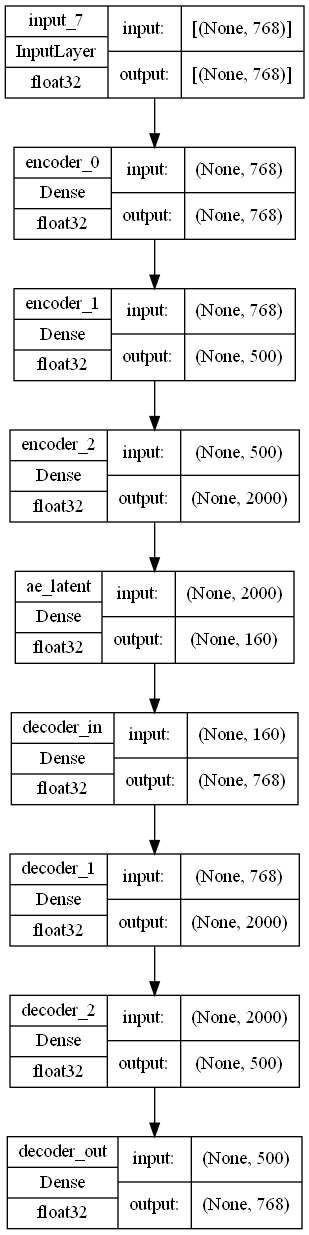

In [18]:
model = create_model(grid[0])
plot_model(model, show_dtype=True, 
            show_layer_names=True, show_shapes=True)

Full df: (3895, 771)
Train df: (3116, 768)
Test df: (779, 768)
Training 4 deep big - 160 latent
Epoch 34: early stopping
...Loss => 6.633363246917725


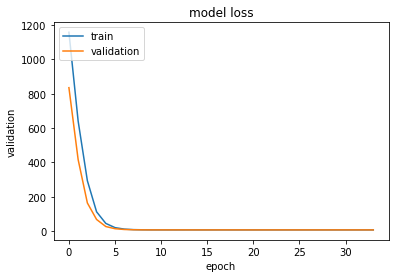

In [19]:

early_stopping_cb = EarlyStopping(
    monitor='loss', patience=15, verbose=1, min_delta=0.0001)

for config in grid:
    train_x, test_x = test_train_split()
    model = create_model(config)
    print(f"Training {config['name']}")
    plot_model(model, show_dtype=True, 
                       show_layer_names=True, show_shapes=True)
    history = model.fit(
        train_x,
        train_x,
        validation_data=(test_x, test_x),
        epochs=2000,
        batch_size=config["batch"],
        shuffle=True,
        verbose=0,
        callbacks=[early_stopping_cb],
    )
    print(f"...Loss => {history.history['loss'][-1]}")
    plot_loss(history)

In [ ]:
# find best latent dims
early_stopping_cb = EarlyStopping(
    monitor='loss', patience=10, verbose=1, min_delta=0.00001)

best_loss = {"dims": 0, "loss": 100}
test_dims = [16, 32, 48, 64, 96, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 256, 512, 768]
# test_dims = range(140, 180, 1)
# test_dims = [168]
test_batches = [1024]
test_history = []
for latent_dim in test_dims:
    for batch_size in test_batches:
        model = create_model(
            layers=[
                {"n": 768, "act": "relu"},
                # {"n": 512, "act": "relu"},
                # {"n": 256, "act": "relu"},
            ],
            latent_layer={"n": latent_dim, "act": "relu"},
            output_fn="tanh",
            optimizer_fn="adam",
            loss_fn="mse",
            verbose=0)
        print(f"Training {latent_dim} latent dims, batch: {batch_size}")
        history = model.fit(
            train_x,
            train_x,
            validation_data=(test_x, test_x),
            epochs=2000,
            batch_size=1024,
            validation_split=0.1,
            shuffle=True,
            verbose=0,
            callbacks=[early_stopping_cb],
        )
        loss = history.history['val_loss'][-1]
        print(f"...Loss => {loss}")
        test_history.append(loss)
        if loss < best_loss["loss"]:
            best_loss = {
                "dims": latent_dim, "loss": loss, "batch_size": batch_size}

# results
plt.plot(test_dims, test_history)
plt.title('autoencoder loss vs latent dims')
plt.ylabel('loss')
plt.xlabel('dimensions')
plt.show()
print(
    f"Best latent dims: {best_loss['dims']}, "
    f"batch:{best_loss['batch_size']} => {best_loss['loss']}")

In [1]:
import os
import numpy as np
from keras.initializers import VarianceScaling
from tensorflow.keras.optimizers import SGD
from DEC import DEC
from metrics import acc

save_dir = "./model"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# load dataset
from datasets import load_reuters
x, y = load_reuters()
n_clusters = len(np.unique(y))

init = 'glorot_uniform'
pretrain_optimizer = 'adam'
# setting parameters

update_interval = 30
pretrain_epochs = 50
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                        distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
pretrain_optimizer = SGD(lr=1, momentum=0.9)


('REUTERSIDF10K samples', (10000, 2000))


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# parser.add_argument('--batch_size', default=256, type=int)
# parser.add_argument('--maxiter', default=2e4, type=int)
# parser.add_argument('--pretrain_epochs', default=None, type=int)
# parser.add_argument('--update_interval', default=None, type=int)
# parser.add_argument('--tol', default=0.001, type=float)
# parser.add_argument('--ae_weights', default=None)
# parser.add_argument('--save_dir', default='results')

In [9]:
# prepare the DEC model
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, init=init)

if os.path.exists(os.path.join(save_dir, 'ae_weights.h5')):
    print("Loading weights")
    dec.autoencoder.load_weights(os.path.join(save_dir, 'ae_weights.h5'))
else:
    print("Training weights")
    dec.pretrain(x=x, y=y, optimizer=pretrain_optimizer,
                    epochs=pretrain_epochs, batch_size=256,
                    save_dir='./results')

dec.model.summary()
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')


Loading weights
Model: "model_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2000)]            0         
                                                                 
 encoder_0 (Dense)           (None, 500)               1000500   
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 clustering (ClusteringLayer  (None, 4)                40        
 )                                                               
                                          

In [10]:
%%timeit 
y_pred = dec.fit(x, y=y, tol=0.001, maxiter=2e4, batch_size=256,
    update_interval=update_interval, save_dir=save_dir)
print('acc:', acc(y, y_pred))


Update interval 30
Save interval 195
Initializing cluster centers with k-means.
313/313 [==============================] - 0s 1ms/step
Iter 0: acc = 0.68290, nmi = 0.47618, ari = 0.50963  ; loss= 0
saving model to: ./model/DEC_model_0.h5
Iter 30: acc = 0.68620, nmi = 0.48075, ari = 0.51546  ; loss= 0.04129
Iter 60: acc = 0.68940, nmi = 0.48683, ari = 0.52078  ; loss= 0.04404
Iter 90: acc = 0.69180, nmi = 0.49303, ari = 0.52576  ; loss= 0.05309
Iter 120: acc = 0.69240, nmi = 0.49583, ari = 0.52761  ; loss= 0.08314
Iter 150: acc = 0.69050, nmi = 0.49670, ari = 0.52684  ; loss= 0.0752
Iter 180: acc = 0.68830, nmi = 0.49795, ari = 0.52598  ; loss= 0.08394
saving model to: ./model/DEC_model_195.h5
Iter 210: acc = 0.68760, nmi = 0.50070, ari = 0.52740  ; loss= 0.0816
Iter 240: acc = 0.68680, nmi = 0.50252, ari = 0.52786  ; loss= 0.06647
Iter 270: acc = 0.68570, nmi = 0.50363, ari = 0.52728  ; loss= 0.07943
Iter 300: acc = 0.68540, nmi = 0.50547, ari = 0.52773  ; loss= 0.08012
Iter 330: acc =